# Using a Convolutional Neural Network (CNN) to Classify Images

Source code here:
https://github.com/wwoo/tf_box_classify

This is a simple example demonstrating how to classify images from a webcam using TensorFlow.  The model is a convolutional neural network (CNN) that classifies images of a box into four classes (upright, tilted, open and spilled).  115 labelled images of each class is used to train the model, with each image processed 10 times due to the small dataset.

In [1]:
import tensorflow as tf
import numpy as np
import os
import time
import math

from IPython.display import display, Image

In [2]:
# hyper parameters to use for training
TRAIN_BATCH_SIZE = 10
TRAIN_EPOCHS = 5
VALID_BATCH_SIZE = 40
VALID_EPOCHS = None
SHUFFLE_BATCHES = True
LEARNING_RATE = 0.01
NUM_CLASSES = 4
KEEP_PROB = 0.75
VALID_STEPS = 10

In [3]:
# image parameters
IMAGE_SIZE = 64
IMAGE_CHANNELS = 3

Let's see a sample of our training images.

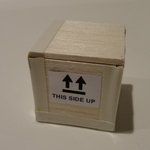

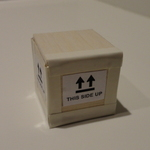

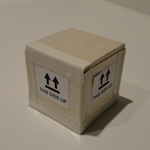

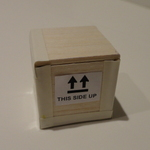

In [4]:
display(Image(filename='images/normal_processed/normal-0.jpg'))
display(Image(filename='images/normal_processed/normal-5.jpg'))
display(Image(filename='images/normal_processed/normal-10.jpg'))
display(Image(filename='images/normal_processed/normal-15.jpg'))

Let's have a look at an excerpt of our labeled training data:

In [5]:
with open('./train.txt', 'r') as f:
    for i in range(0, 20):
        print(f.readline().rstrip())

./images/open_processed/open-0.jpg 0
./images/open_processed/open-1.jpg 0
./images/open_processed/open-10.jpg 0
./images/open_processed/open-100.jpg 0
./images/open_processed/open-101.jpg 0
./images/open_processed/open-102.jpg 0
./images/open_processed/open-103.jpg 0
./images/open_processed/open-104.jpg 0
./images/open_processed/open-105.jpg 0
./images/open_processed/open-106.jpg 0
./images/open_processed/open-107.jpg 0
./images/open_processed/open-108.jpg 0
./images/open_processed/open-109.jpg 0
./images/open_processed/open-11.jpg 0
./images/open_processed/open-110.jpg 0
./images/open_processed/open-111.jpg 0
./images/open_processed/open-112.jpg 0
./images/open_processed/open-113.jpg 0
./images/open_processed/open-114.jpg 0
./images/open_processed/open-12.jpg 0


Our validation dataset is similarly labeled.

In [6]:
with open('./valid.txt', 'r') as f:
    for i in range(0, 20):
        print(f.readline().rstrip())

./images/validation/normal-0.jpg 2
./images/validation/normal-1.jpg 2
./images/validation/normal-2.jpg 2
./images/validation/normal-3.jpg 2
./images/validation/normal-4.jpg 2
./images/validation/normal-5.jpg 2
./images/validation/normal-6.jpg 2
./images/validation/normal-7.jpg 2
./images/validation/normal-8.jpg 2
./images/validation/normal-9.jpg 2
./images/validation/open-0.jpg 0
./images/validation/open-1.jpg 0
./images/validation/open-2.jpg 0
./images/validation/open-3.jpg 0
./images/validation/open-4.jpg 0
./images/validation/open-5.jpg 0
./images/validation/open-6.jpg 0
./images/validation/open-7.jpg 0
./images/validation/open-8.jpg 0
./images/validation/open-9.jpg 0


We're going to use TensorFlow input queues to read our training and validation data.  Labeled training data is read from `train.txt`, and validation data from `valid.txt`.

`get_batch_inputs` to retrieve the next `TRAIN_BATCH_SIZE` batch of labeled data during training and validation. 

Assuming images are 150 x 150 pixels (single channel / grayscale) and using a batch size of 10, `get_batch_inputs` returns two values:

1. A 4-D tensor of shape [150, 150, IMAGE_CHANNELS, TRAIN_BATCH_SIZE], which is a batch training images
2. A 2-D tensor of shape [4, 10], which is the corresponding batch of labels represented as "one-hot" vectors

In [7]:
def get_batch_inputs(train_file, batch_size=TRAIN_BATCH_SIZE, num_epochs=TRAIN_EPOCHS):
    image_list, label_list = get_image_label_list(train_file)
    input_queue = tf.train.slice_input_producer([image_list, label_list],
        num_epochs=num_epochs, shuffle=SHUFFLE_BATCHES)
    image, label = read_image_from_disk(input_queue)
    image = tf.reshape(image, [IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS])
    image_batch, label_batch = tf.train.batch([image, label],
        batch_size=batch_size)

    return image_batch, tf.one_hot(tf.to_int64(label_batch),
        NUM_CLASSES, on_value=1.0, off_value=0.0) 

We'll also define a few helper functions called by `get_batch_inputs`: 

`get_image_label_list` to read our text files into lists. 

`read_image_from_disk` to convert JPEG images on disk to tensors.

In [8]:
def read_image_from_disk(input_queue):
    label = input_queue[1]
    file_contents = tf.read_file(input_queue[0])
    rgb_image = tf.image.decode_jpeg(file_contents, channels=IMAGE_CHANNELS,
        name="decode_jpeg")
    rgb_image = tf.image.resize_images(rgb_image, [IMAGE_SIZE, IMAGE_SIZE])

    return rgb_image, label

def get_image_label_list(image_label_file):
    filenames = []
    labels = []
    for line in open(image_label_file, "r"):
        filename, label = line[:-1].split(' ')
        filenames.append(filename)
        labels.append(int(label))

    return filenames, labels

Define some helper functions for convolution and max pooling.

`conv2d` combines a convolution with a stride of 1 and same padding, and activation via ReLU.

`maxpool2d` performs max pool sampling, which essentially halves the size of the input tensor.


In [9]:
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1],
        padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def maxpool2d(x, k=2, layer=""):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, k, k, 1],
        strides=[1, k, k, 1], padding='SAME')

`conv_net` builds most of the CNN specific parts of our TensorFlow graph. 

Each layer of the CNN performs a convolution, ReLU activation and sample (maxpool), then feeds the output to the next CNN layer.

In [10]:
def conv_net(x, weights, biases, image_size, keep_prob=KEEP_PROB):
    # Convolution and max pooling layers
    # Each max pooling layer reduces dimensionality by 2
    with tf.name_scope('layer1'):
        # Convolution and max pooling layer 1
        conv1 = conv2d(x, weights['wc1'], biases['bc1'])
        conv1 = maxpool2d(conv1, k=2)

    with tf.name_scope('layer2'):
        # Convolution and max pooling layer 2
        conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
        conv2 = maxpool2d(conv2, k=2)

    with tf.name_scope('layer3'):
        # Convolution and max pooling layer 3
        conv3 = conv2d(conv2, weights['wc3'], biases['bc3'])
        conv3 = maxpool2d(conv3, k=2)

    with tf.name_scope('layer4'):
        # Convolution and max pooling layer 4
        conv4 = conv2d(conv3, weights['wc4'], biases['bc4'])
        conv4 = maxpool2d(conv4, k=2)

    with tf.name_scope('fully_connected'):
        # Fully-connected layer
        fc1 = tf.reshape(conv4, [-1, weights['wd1'].get_shape().as_list()[0]])
        fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
        fc1 = tf.nn.relu(fc1)

        # Apply dropout
        fc1 = tf.nn.dropout(fc1, keep_prob)

    with tf.name_scope('output'):
        # Output, class prediction
        out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])

    return out

Purely for debugging and educational purposes, generate a summary of (one) first layer convolution and activation.  These can be viewed in Tensorboard, which is a tool for visualising TensorFlow graphs.

In [11]:
def generate_image_summary(x, weights, biases, step, image_size=IMAGE_SIZE):
    with tf.name_scope('generate_image_summary'):
        x =  tf.slice(x, [0, 0, 0, 0],
            [VALID_BATCH_SIZE, image_size, image_size, 3])
        x = tf.nn.conv2d(x, weights['wc1'], strides=[1, 1, 1, 1],
            padding='SAME')

        # Nifty grid image summary via:
        # http://stackoverflow.com/questions/33802336/visualizing-output-of-convolutional-layer-in-tensorflow

        x = tf.slice(x, [0, 0, 0, 0], [1, -1, -1, -1])
        x = tf.reshape(x, [IMAGE_SIZE, IMAGE_SIZE, 32])

        pad_xy = image_size + 4
        x = tf.image.resize_image_with_crop_or_pad(x, pad_xy, pad_xy)
        x = tf.reshape(x, [pad_xy, pad_xy, 4, 8])
        x = tf.transpose(x, [2, 0, 3, 1])
        x = tf.reshape(x, [1, pad_xy * 4, pad_xy * 8, 1])

        conv_summary = tf.summary.image("img_conv_{:05d}".format(step), x)
        relu_summary = tf.summary.image("img_relu_{:05d}".format(step), tf.nn.relu(x))

    return conv_summary, relu_summary

With all our helper functions defined, we're ready to start building our TensorFlow graph.

Firstly, create input nodes to retrieve image batches. We'll define two batches:

`train_image_batch` and `train_label_batch` to get the next batch of training images and corresponding labels.  These are fed into `x_` and `y_` placeholders for each step of training.

In [12]:
# Read inventory of training images and labels
with tf.name_scope('batch_inputs'):
    train_file = "./train.txt"
    valid_file = "./valid.txt"

    image_size = IMAGE_SIZE

    train_image_batch, train_label_batch = get_batch_inputs(train_file,
            batch_size=TRAIN_BATCH_SIZE, num_epochs=TRAIN_EPOCHS)
    valid_image_batch, valid_label_batch = get_batch_inputs(valid_file,
            batch_size=VALID_BATCH_SIZE, num_epochs=VALID_EPOCHS)

# These are image and label batch placeholders which we'll feed in during training
x_ = tf.placeholder("float32", shape=[None, image_size, image_size,
    IMAGE_CHANNELS])

y_ = tf.placeholder("float32", shape=[None, NUM_CLASSES])

Define weights and biases for each of our convolution layers:

In [13]:
# k is the image size after 4 convolution layers
k = int(math.ceil(IMAGE_SIZE / 2.0 / 2.0 / 2.0 / 2.0))

# Store weights for our convolution & fully-connected layers
with tf.name_scope('weights'):
    weights = {
        # 5x5 conv, 3 input channel, 32 outputs each
        'wc1': tf.Variable(tf.random_normal([5, 5, 1 * IMAGE_CHANNELS, 32])),
        # 5x5 conv, 32 inputs, 64 outputs
        'wc2': tf.Variable(tf.random_normal([5, 5, 32, 64])),
        # 5x5 conv, 64 inputs, 128 outputs
        'wc3': tf.Variable(tf.random_normal([5, 5, 64, 128])),
        # 5x5 conv, 128 inputs, 256 outputs
        'wc4': tf.Variable(tf.random_normal([5, 5, 128, 256])),
        # fully connected, k * k * 256 inputs, 1024 outputs
        'wd1': tf.Variable(tf.random_normal([k * k * 256, 1024])),
        # 1024 inputs, 2 class labels (prediction)
            'out': tf.Variable(tf.random_normal([1024, NUM_CLASSES]))
    }

# Store biases for our convolution and fully-connected layers
with tf.name_scope('biases'):
    biases = {
        'bc1': tf.Variable(tf.random_normal([32])),
        'bc2': tf.Variable(tf.random_normal([64])),
        'bc3': tf.Variable(tf.random_normal([128])),
        'bc4': tf.Variable(tf.random_normal([256])),
        'bd1': tf.Variable(tf.random_normal([1024])),
        'out': tf.Variable(tf.random_normal([NUM_CLASSES]))
    }

Dropping some of our activations will help prevent over-fitting on our training data.

In [14]:
# Define dropout rate to prevent overfitting
keep_prob = tf.placeholder(tf.float32)

Now that we've defined our weights, biases and dropout probability, we can call `conv_net` to run our current batch input through the convolution, maxpool and fully-connected layers.

The output from the fully-connected layer is a set of probability distributions across our `NUM_CLASSES`.

In [15]:
# Build our graph
pred = conv_net(x_, weights, biases, image_size, keep_prob)

We now measure the "loss" between our predicted probability distributions and the true distributions from our one-hot vectors.

In [16]:
# Calculate loss
with tf.name_scope('cross_entropy'):
    # Define loss and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y_))
    cost_summary = tf.summary.scalar("cost_summary", cost)

Next, we define a training step to minimise the loss between the predicted and true distribution.  TensorFlow keeps track of the whole graph and performs auto-differentation at each step.

In [17]:
# Run optimizer step
with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(cost)

Optionally, we'll define some steps to check the accuracy of our training.  We'll call this every n steps and write out a summary for visualisation via Tensorboard.

In [18]:
# Evaluate model accuracy
with tf.name_scope('predict'):
    correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    accuracy_summary = tf.summary.scalar("accuracy_summary", accuracy)
    w_summary = tf.summary.histogram("weights", weights['wc1'])
    b_summary = tf.summary.histogram("biases", biases['bc1'])

At this point, we've finished defining what our graph looks like.  To start running the graph we've built, we need to create a TensorFlow session and initialize the variables in our graph:

In [21]:
sess = tf.Session()

writer = tf.summary.FileWriter("./logs", sess.graph)

init_op = tf.global_variables_initializer()
init_local_op = tf.local_variables_initializer()

We're using TensorFlow input queues to feed our graph with each new batch of training data, until all the data is considered.

Each image in the training set is used to train our model `TRAIN_EPOCHS` times.  The input queue runner retrieves the next batch of training images and labels, feeds these into the `x_` and `y_` placeholders.  We then run `train_step` to execute one step of our training.  Since TensorFlow has a complete view of our graph dependencies, it runs all the previous dependent nodes of the graph before `train_step`.

In [22]:
with sess.as_default():
    
    sess.run(init_op)
    sess.run(init_local_op)
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    
    step = 0
    
    print(" == Start training == ")
    
    try:
        while not coord.should_stop():
            step += 1
            x, y = sess.run([train_image_batch, train_label_batch])
            train_step.run(feed_dict={keep_prob: 0.75, x_: x, y_: y})

            if step % TRAIN_BATCH_SIZE == 0:
                x, y = sess.run([valid_image_batch, valid_label_batch])
                conv_summary, relu_summary = generate_image_summary(x_, weights, biases, step, image_size)
                result = sess.run([cost_summary, accuracy_summary, accuracy, conv_summary, relu_summary, w_summary, 
                                   b_summary], feed_dict={keep_prob: 1.0, x_: x, y_: y})

                cost_summary_str = result[0]
                accuracy_summary_str = result[1]
                acc = result[2]
                conv_summary_str = result[3]
                relu_summary_str = result[4]
                w_summary_str = result[5]
                b_summary_str = result[6]

                # write summaries for viewing in Tensorboard
                writer.add_summary(accuracy_summary_str, step)
                writer.add_summary(cost_summary_str, step)
                writer.add_summary(conv_summary_str, step)
                writer.add_summary(relu_summary_str, step)
                writer.add_summary(w_summary_str, step)
                writer.add_summary(b_summary_str, step)

                print("Accuracy at step %s: %s" % (step, acc))    
                    
    except tf.errors.OutOfRangeError:
        x, y = sess.run([valid_image_batch, valid_label_batch])
        result = sess.run([accuracy], feed_dict={keep_prob: 1.0, x_: x, y_: y})
        
        print("Validation accuracy: %s" % result[0])

    finally:
        coord.request_stop()
        coord.join(threads)
        sess.close()    
        
print("You done! (☞ﾟヮﾟ)☞")

 == Start training == 
Accuracy at step 10: 0.25
Accuracy at step 20: 0.625
Accuracy at step 30: 0.775
Accuracy at step 40: 0.85
Accuracy at step 50: 0.775
Accuracy at step 60: 0.975
Accuracy at step 70: 0.975
Accuracy at step 80: 0.9
Accuracy at step 90: 0.975
Accuracy at step 100: 1.0
Accuracy at step 110: 0.875
Accuracy at step 120: 1.0
Accuracy at step 130: 0.825
Accuracy at step 140: 0.975
Accuracy at step 150: 0.95
Accuracy at step 160: 0.975
Accuracy at step 170: 1.0
Accuracy at step 180: 0.9
Accuracy at step 190: 0.975
Accuracy at step 200: 1.0
Accuracy at step 210: 1.0
Accuracy at step 220: 1.0
Accuracy at step 230: 1.0
Validation accuracy: 1.0
You done! (☞ﾟヮﾟ)☞
